In [1]:
%load_ext autoreload
%autoreload 3 --print
# import os; os.environ['JAX_PLATFORM_NAME'] = 'cpu'
# import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

In [4]:
from kpsn.project.paths import Project, create_model
from kpsn.io import loaders
from kpsn.models import joint
from kpsn import config
from kpsn.models import instantiation, setup, pose, morph, util as model_util
from kpsn import fitting
from kpsn.fitting import em
from kpsn.io import alignment, features
from kpsn.io.armature import Armature
from kpsn.fitting import methods
from kpsn.fitting import scans
from kpsn.io.dataset import PytreeDataset
import os, sys, shutil
import numpy as np
from pprint import pprint
import jax.numpy as jnp
from kpsn import viz
from kpsn.viz import styles
import matplotlib.pyplot as plt
from collections import defaultdict
import os, re
import tqdm
import joblib as jl

from pathlib import Path
import logging
logging.getLogger().setLevel(logging.INFO)

ImportError: cannot import name 'PRNGKeyArray' from 'jaxtyping' (/Users/calebweinreb/miniconda3/envs/keypoint_moseq/lib/python3.9/site-packages/jaxtyping/__init__.py)

In [64]:
# Define paths

data_root = '../../../data_explore/data'

In [52]:
# Create mapping of session names (ie 3wk_m0) to keypoint data paths

modata_npy_name_func = (lambda path, *a:
    match.group(1) if ((match := re.search(r"\d{2}_\d{2}_\d{2}_(\d+wk_m\d+)\.npy", path)) is not None) else None)
session_paths = dict(filter(lambda x: x[0] is not None, [(modata_npy_name_func(m), str(Path(data_root) / m)) for m in os.listdir(data_root)]))
# throw out 9-12 week
session_ages = {s: s.split('_')[0].strip('wk') for s in session_paths}
ages = set(session_ages.values())
ages = list(filter(lambda x: x not in ["5", "7", "9", "12", "24", "52", "72"], ages))
session_paths = {s: p for s, p in session_paths.items() if session_ages[s] in ages}
session_bodies = {s: f'body-{session_ages[s]}wk' for s in session_paths}
ref_age = "3"

age_dates =  {
    "3" : "10_11_22",
    "5" : "10_24_22",
    "7" : "10_24_22",
    "24": "11_03_22",
    "52" : "11_03_22",
    "72" : "10_14_22",
}

print("sessions:", session_paths.keys())

raw_keypoints = {
    s: np.load(p) for s, p in session_paths.items()
}

sessions: dict_keys(['3wk_m1', '3wk_m0', '3wk_m2', '3wk_m3'])


## 2D project

- Sessions: "A" and "B"
- Bodies: "E" and "F"
- Pose distributions: 3 Gaussian components arranged in a triangle. One
  spherical and two with opposite correlation between the two variables. One of
  sessions "A" and "B" will have high weight on each of the
  oppositely-correlated components.
- Morphs: offset along $x$ axis with opposite skew along $y$ axis.

Each session will contain data from a 2D Gaussian mixture mapped under an affine
transform.



##### Issues
- Pose component count selection
- Calibration plots

##### Dataset generation

In [107]:
def create_dataset_2d(
    sessions,
    bodies,
    session_bodies,
    n_frames,
    n_components,
    weights,
    means,
    covs,
    transform_matrices,
    transform_biases,
    ref_session=None,
    keypoint_names=None,
    seed=None,
):
    """
    Create a dictionary of keyword arguments for creating a project from a 2D
    test dataset.

    Args:
        sessions (list):
            The number of sessions in the model.
        bodies (list):
            The number of bodies in the model.
        session_bodies (dict):
            A mapping of session names to body names.
        n_frames (int):
            Number of samples to generate for each session.
        n_components (int):
            The number of components in the model.
        weights (np.ndarray, shape (n_sessions, n_components,)):
            The weights of the model, ordered as the list of session names.
        means (np.ndarray, shape (n_components, 2)):
            The means of the Gaussian componets.
        covs (np.ndarray, shape (n_components, 2, 2)):
            The covariances of the Gaussian componets.
        transform_matrices (np.ndarray, shape (n_sessions, 2, 2)):
            The transformation matrices of the affine morph to be applied to the
            data generated by the mixture model.
        transform_biases (np.ndarray, shape (n_sessions, 2)):
            The transformation biases of the affine morph.
        ref_session : str
            The reference session name or `None` to select the first session.
        keypoint_names (list):
            The names of the dimensions of the model data, or `None` to use
            integer indices (converted to strings).
        seed (int):
            The random seed to use for generating the data.

    Returns:
        project_config_kws (dict):
            A dictionary of keyword arguments for creating a project, containing
            keys 'session_names`, `bodies`, `ref_session`.
        raw_keypoints (dict):
            A dictionary of raw keypoint data, containing a key for each
            session name mapping to data of shape (n_frames, 2, 1)
        component_ids (dict):
            A dictionary of arrays containing the component index of each frame
            for each session.
    """

    # convert parameters to arrays
    weights = np.array(weights)
    means = np.array(means)
    covs = np.array(covs)
    transform_matrices = np.array(transform_matrices)
    transform_biases = np.array(transform_biases)

    # check sum to 1 and psd
    assert np.allclose(weights.sum(axis=1), 1)
    assert np.all(np.linalg.eigvals(covs) > 0)

    # setup
    n_bodies = len(bodies)
    n_sessions = len(sessions)
    rng = np.random.default_rng(seed)
    ref_session = ref_session or sessions[0]
    keypoint_names = keypoint_names or [str(i) for i in range(2)]
    keypoint_parents = [None] + [k for k in keypoint_names[:-1]]

    # sample component IDs
    component_ids = {
        s: rng.choice(n_components, size=n_frames, p=weights[i])
        for i, s in enumerate(sessions)
    }
    # sample gaussian noise and transform according to component IDs
    poses = {
        s: np.einsum(
            "ijk,ik->ij",
            np.linalg.cholesky(covs)[component_ids[s]],
            rng.multivariate_normal(np.zeros(2), np.eye(2), size=n_frames),
        )
        + means[component_ids[s]]
        for s in sessions
    }
    # apply affine transform
    observations = {
        s: (np.einsum("ij,aj->ai", transform_matrices[i], poses[s])
        + transform_biases[i])[..., None]
        for i, s in enumerate(sessions)
    }

    # create project config
    project_config_kws = {
        "session_names": sessions,
        "bodies": session_bodies,
        "ref_session": ref_session,
        "keypoint_names": keypoint_names,
        "keypoint_parents": keypoint_parents,
    }

    return project_config_kws, observations, component_ids

In [190]:
project_config_kws, raw_keypoints, component_ids = create_dataset_2d(
    sessions = ["A", "B"],
    bodies = ["E", "F"],
    session_bodies = {"A": "E", "B": "F"},
    n_frames = 300,
    n_components = 3,
    weights = np.array([[4, 1, 1], [1, 1, 4]]) / 6,
    means = [
        [1, 0],
        [0, 1],
        [-1, 0]
    ],
    covs = np.array([
        [[1, 0.8], [0.8, 1]],
        [[1, 0], [0, 1]],
        [[1, -0.8], [-0.8, 1]],
    ]) / 9,
    transform_matrices = [
        [[1, 0], [0, 1]],
        [[1, 0], [0, 1]],
    ],
    transform_biases = [
        [1, 0],
        [-1, 0],
    ],
    ref_session = "A",
    keypoint_names = None,
    seed = 0,
)

In [136]:
# Create base project config to override

project_dir = Path('../projects/unit-test/2d')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')


loaders.arrays.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='none',
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

##### Calibration and training

In [150]:
# Calibration

# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(raw_keypoints, cfg["dataset"])

dataset, cfg = alignment.no_alignment.calibrate(dataset, cfg)

cfg = features.pcs.calibrate(dataset, cfg)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["calibration"]["tgt_variance"] = 0.99
cfg["morph"]["prior_mode"] = "distance"
cfg["fit"]["n_steps"] = 400
cfg["fit"]["learning_rate"] = 1e0
cfg["fit"]["mstep_stop_window"] = None

cfg = pose.gmm.calibrate_base_model(dataset, cfg, n_components=3)
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg, n_dims=2)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

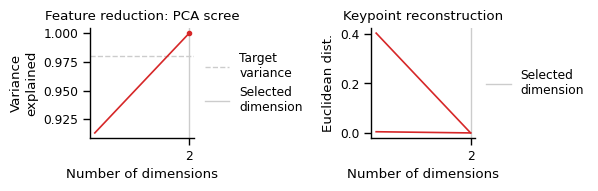

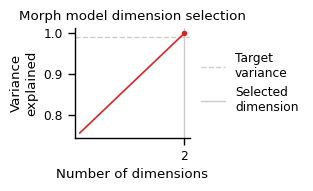

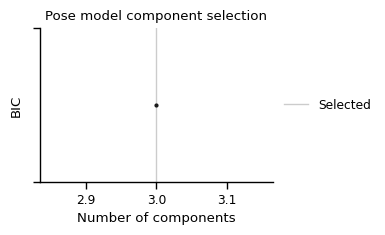

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/unit-test/2d/models/morph-prior-scan_1/plots/pose_calibration.pdf')

In [151]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

In [152]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "morph-prior-scan", {
    'morph.dist_var': [1e-1, 1e1]
})
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(raw_keypoints, cfg["dataset"])
scan_dataset, split_meta, _ = scans.prepare_scan_dataset(dataset, project, "morph-prior-scan", return_session_inv=True)

In [153]:
scans.run_scan(project, "morph-prior-scan", scan_dataset, log_every=50)

INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 150 frames
INFO:root:Adjusting learning rate:1.0 -> 0.0016666666666666668
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 1308.1756591796875
INFO:root:Step 50 : loss = 770.6285400390625
INFO:root:Step 100 : loss = 770.62841796875
INFO:root:Step 150 : loss = 770.628173828125
INFO:root:Step 200 : loss = 770.6290283203125
INFO:root:Step 250 : loss = 770.6324462890625
INFO:root:Step 300 : loss = 770.6280517578125
INFO:root:Step 350 : loss = 770.62548828125
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 150 frames
INFO:root:Adjusting learning rate:1.0 -> 0.0016666666666666668
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 1156.5655517578125
INFO:root:Step 50 : loss = 964.8106079101562
INFO:root:Step 100 : loss = 964.8123168945312
INFO:root:Step 150 : loss = 964.811279296875
INFO:root:Step 200 : loss = 964.810302734375
INF

#### Standard training diagnostics

  0%|          | 0/2 [00:00<?, ?it/s]

Plotting morph-prior-scan_0
- reports


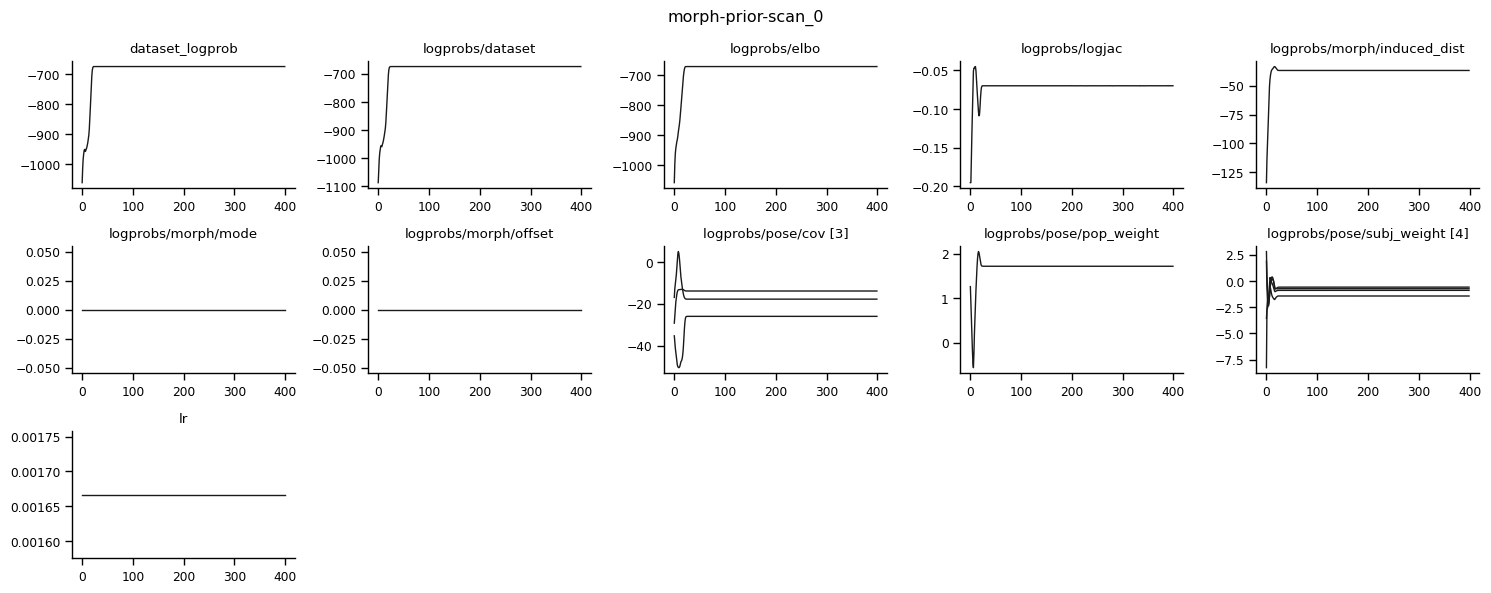

100%|██████████| 400/400 [00:00<00:00, 892.55it/s]


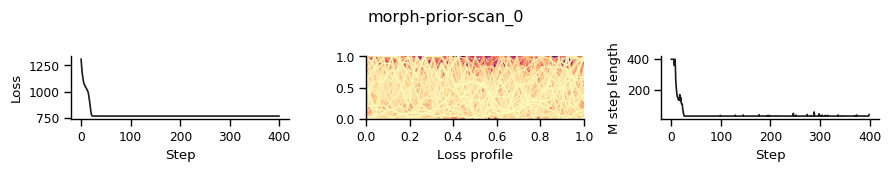

- morph


100%|██████████| 4/4 [00:00<00:00, 71.34it/s]


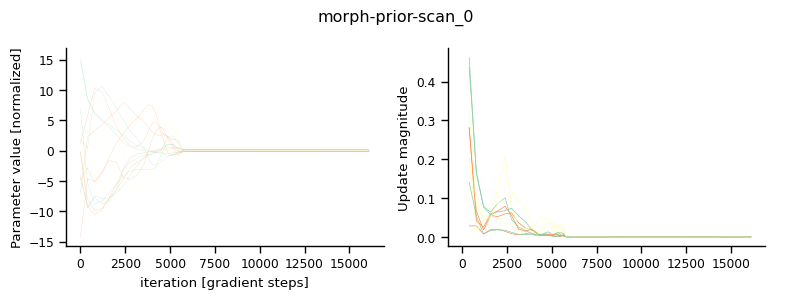

- gmm


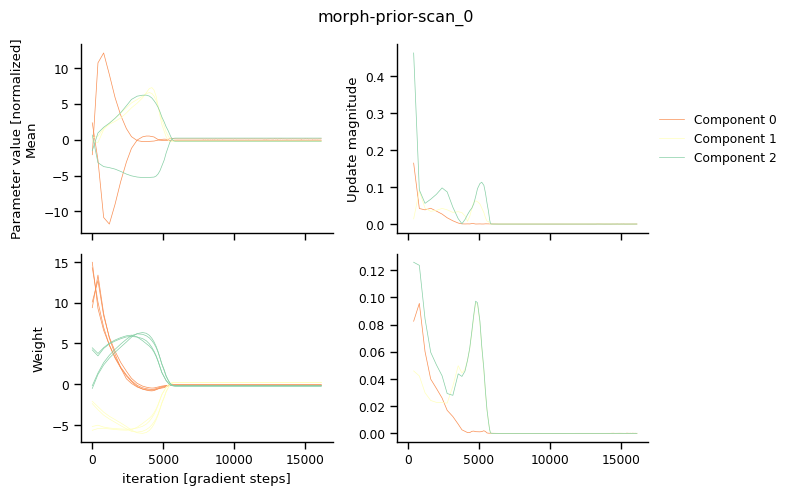

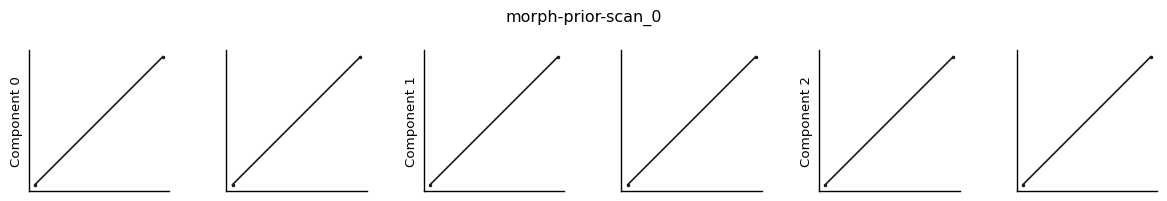

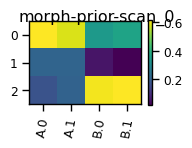

 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Plotting morph-prior-scan_1
- reports


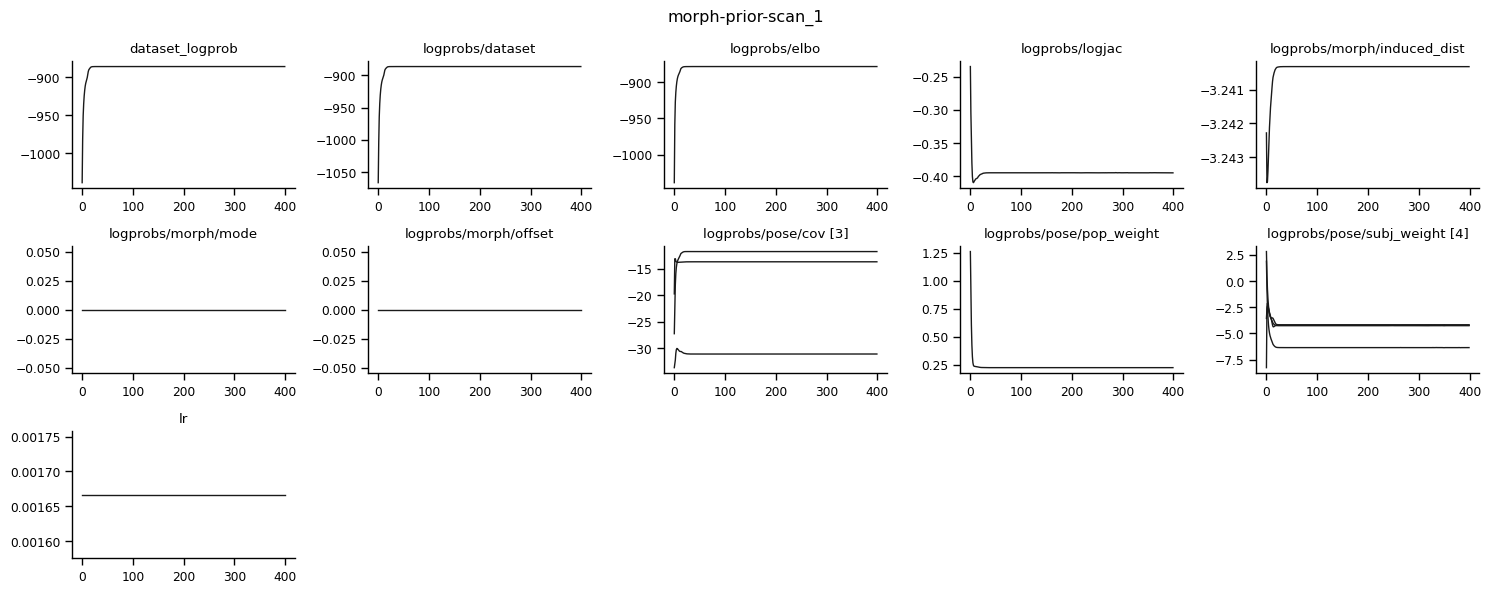

100%|██████████| 400/400 [00:00<00:00, 1049.36it/s]


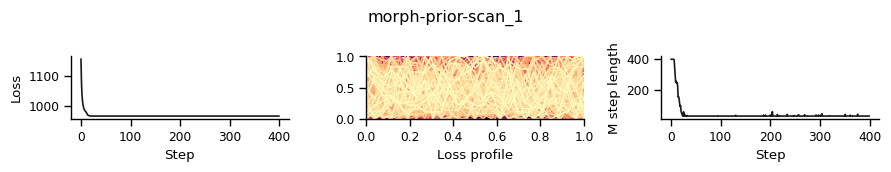

- morph


100%|██████████| 4/4 [00:00<00:00, 74.53it/s]


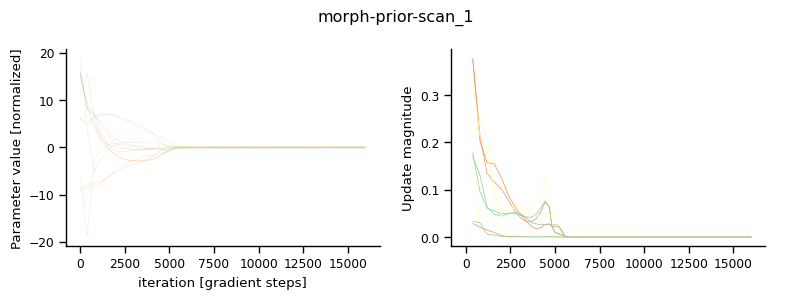

- gmm


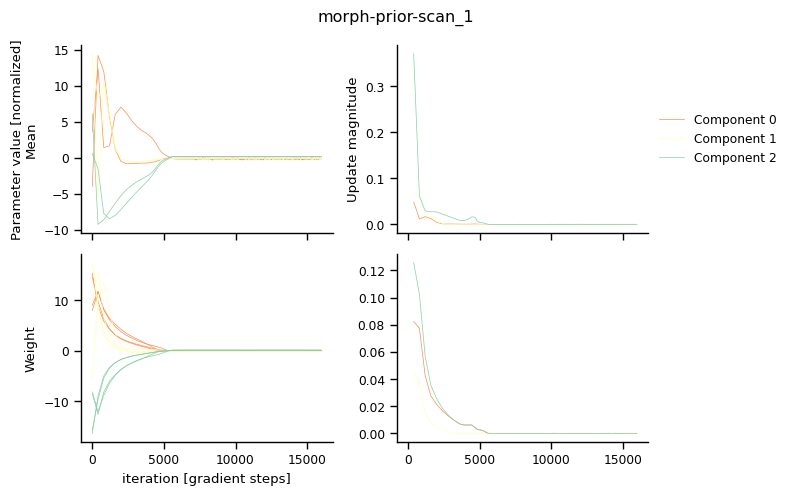

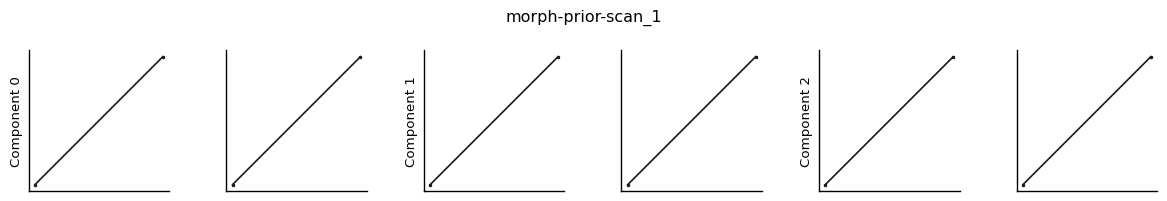

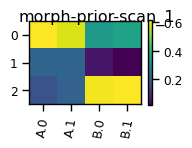

100%|██████████| 2/2 [00:04<00:00,  2.45s/it]


In [154]:
progress = True
models = list(scan_cfg['models'].keys())

for model_name in model_util._optional_pbar(models, progress):

    print("Plotting", model_name)
    ckpt = methods.load_fit(project.model(model_name))
    ckpt["config"] = config.load_model_config(project.model_config(model_name))
    (project.model(model_name) / "plots").mkdir(exist_ok = True)
    plotter.plot_dir = str(project.model(model_name) / "plots")

    print("- reports")
    fig = viz.model.report_plots(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, "reports")

    fig = viz.model.em_loss(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, "em_loss")

    print("- morph")
    fig = viz.model.lra_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True)
    fig.suptitle(model_name)
    plotter.finalize(fig, "morph_convergence")

    print("- gmm")
    fig = viz.model.gmm_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True)
    fig.suptitle(model_name)
    plotter.finalize(fig, "gmm_convergence")

    mean_fig, wt_fig = viz.model.gmm_components(ckpt, dataset=scan_dataset)
    mean_fig.suptitle(model_name)
    wt_fig.suptitle(model_name)
    plotter.finalize(mean_fig, "gmm_means")

100%|██████████| 2/2 [00:00<00:00, 13.86it/s]


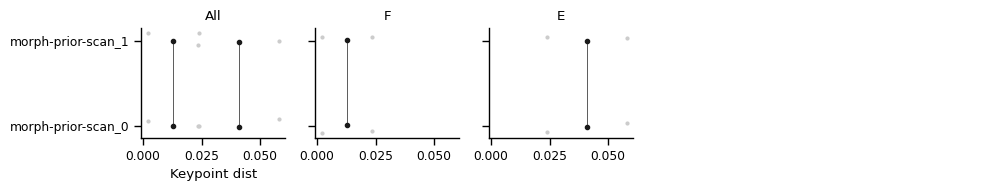

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/unit-test/2d/scans/morph-prior-scan/plots/reconst_errs.pdf')

In [155]:
fig = viz.scans.withinbody_induced_errs(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
plot_dir = (project.scan('morph-prior-scan') / "plots")
plot_dir.mkdir(exist_ok = True)
plotter.plot_dir = str(plot_dir)
plotter.finalize(fig, "reconst_errs")

##### Dataset-specific results

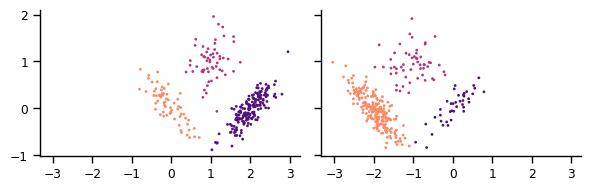

In [191]:
component_pal = np.array(colors.cts(3))
fig, ax = plt.subplots(1, 2, figsize=(6, 2), sharex=True, sharey=True)
ax[0].scatter(*raw_keypoints["A"][..., 0].T, c=component_pal[component_ids["A"]], s = 4, lw=0)
ax[1].scatter(*raw_keypoints["B"][..., 0].T, c=component_pal[component_ids["B"]], s = 4, lw=0)
plotter.finalize(fig, None)

In [192]:
def get_component_assignments(
    poses_dataset,
    pose_model,
    params
):
    logp = pose_model.pose_logprob(params, poses_dataset)
    return poses_dataset.update(data = jnp.argmax(logp, axis = -1))


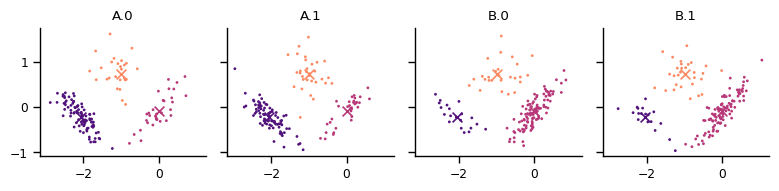

In [199]:
model_name = models[0]
plot_iters = [200]
ckpt = methods.load_fit(project.model(model_name))
model = instantiation.get_model(ckpt["config"])
step_params = scans.select_param_step(
    model, ckpt["params"], ckpt["meta"]["param_hist"], plot_iters[0]
)
canonicalized = model_util.apply_bodies(
    model.morph,
    step_params.morph,
    scan_dataset,
    {s: "body-A.0" for s in scan_dataset.sessions},
)
step_compon_ids = get_component_assignments(
    canonicalized,
    model.pose,
    step_params.pose,
)
fig, ax = plt.subplots(1, 4, figsize=(8, 2), sharex=True, sharey = True)
for i, sess in enumerate(scan_dataset.sessions):
    ax[i].scatter(
        *canonicalized.get_session(sess).T,
        c=component_pal[step_compon_ids.get_session(sess)],
        s=4,
        lw=0,
    )
    ax[i].set_title(sess)
for a in ax:
    for i_comp in range(3):
        a.scatter(
            *step_params.pose.means[i_comp, None].T,
            c=[component_pal[i_comp]],
            marker="x",
            s=50,
        )
plotter.finalize(fig, None)